# ⚽ Análisis de Estadísticas de Partidos de Fútbol con Pandas

Este notebook utiliza Pandas para el análisis de datos de fútbol.

In [1]:
# Importar dependencias

# OS
import os

# Pandas
import pandas as pd

# Importar Matplotlib
import matplotlib.pyplot as plt

In [2]:
# Lectura variables de entorno
TOP_TEAMS_TO_DISPLAY = int(os.getenv("TOP_TEAMS_TO_DISPLAY", 5))
TOP_SCORERS_TO_DISPLAY = int(os.getenv("TOP_SCORERS_TO_DISPLAY", 5))
MINUTE_SEGMENTS = int(os.getenv("MINUTE_SEGMENTS", 15))
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "output")
GOALS_BY_TEAM_FILE_NAME = os.getenv("GOALS_BY_TEAM_FILE_NAME", "goals_by_team.csv")
TOP_SCORERS_FILE_NAME = os.getenv("TOP_SCORERS_FILE_NAME", "top_scorers.csv")
MINUTE_SEGMENTS_FILE_NAME = os.getenv("MINUTE_SEGMENTS_FILE_NAME", "goals_by_minute.png")

# Imprimir variables de entorno
print ("Variables de entorno:")
print ("\t- TOP_TEAMS_TO_DISPLAY: ", TOP_TEAMS_TO_DISPLAY)
print ("\t- TOP_SCORERS_TO_DISPLAY: ", TOP_SCORERS_TO_DISPLAY)
print ("\t- MINUTE_SEGMENTS: ", MINUTE_SEGMENTS)
print ("\t- OUTPUT_DIR: ", OUTPUT_DIR)
print ("\t- GOALS_BY_TEAM_FILE_NAME: ", GOALS_BY_TEAM_FILE_NAME)
print ("\t- TOP_SCORERS_FILE_NAME: ", TOP_SCORERS_FILE_NAME)
print ("\t- MINUTE_SEGMENTS_FILE_NAME: ", MINUTE_SEGMENTS_FILE_NAME)

Variables de entorno:
	- TOP_TEAMS_TO_DISPLAY:  5
	- TOP_SCORERS_TO_DISPLAY:  5
	- MINUTE_SEGMENTS:  15
	- OUTPUT_DIR:  output
	- GOALS_BY_TEAM_FILE_NAME:  goals_by_team.csv
	- TOP_SCORERS_FILE_NAME:  top_scorers.csv
	- MINUTE_SEGMENTS_FILE_NAME:  goals_by_minute.png


In [3]:
# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

---

## 🥅 Goleadores por Partido (`goalscorers.csv`)

### Carga inicial

In [4]:
scorers_df = pd.read_csv("goalscorers.csv")

### Exploración inicial

In [5]:
scorers_df.head()

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,2023-08-12,Manchester Utd,Wolves,Manchester Utd,Rashford M.,15,NaN,NaN
1,2023-08-12,Arsenal,Nottingham Forest,Arsenal,Saka B.,8,NaN,NaN
2,2023-08-12,Arsenal,Nottingham Forest,Nottingham Forest,Awoniyi T.,42,NaN,NaN
3,2023-08-12,Arsenal,Nottingham Forest,Arsenal,Odegaard M.,78,NaN,NaN
4,2023-08-12,Chelsea,Liverpool,Chelsea,Sterling R.,25,NaN,NaN


### Goles por equipo
Cálculo de goles por equipo (excluyendo goles en propia puerta)

In [6]:
# Agrupamos por equipo y contamos cuántos goles han marcado,
# filtrando previamente los goles en propia puerta para no alterar el dato real de goles a favor
goals_by_team = (
    scorers_df
        .loc[scorers_df["own_goal"].isna()]
        .groupby("team")
        .size()
        .reset_index(name="goals")
        .sort_values("goals", ascending=False)
)

# Guardar en un fichero los equipos con más goles
goals_by_team.head(TOP_TEAMS_TO_DISPLAY).to_csv(OUTPUT_DIR + "/" + GOALS_BY_TEAM_FILE_NAME, index=False)

# Mostrar los equipos con más goles
goals_by_team.head(TOP_TEAMS_TO_DISPLAY)

,team,goals
15,France,28
36,Portugal,26
0,Argentina,19
9,Brazil,14
16,Germany,12


### Top goleadores
Cálculo del top de goleadores (excluyendo goles en propia puerta)

In [7]:
# Agrupamos por jugador y contamos cuántos goles han marcado,
# filtrando previamente los goles en propia puerta para no alterar el dato real de goles a favor
top_scorers = (
    scorers_df
        .loc[scorers_df["own_goal"].isna()]
        .groupby("scorer")
        .size()
        .reset_index(name="goals")
        .sort_values("goals", ascending=False)
)

# Guardar en un fichero los máximos goleadores
top_scorers.head(TOP_SCORERS_TO_DISPLAY).to_csv(OUTPUT_DIR + "/" + TOP_SCORERS_FILE_NAME, index=False)

# Mostrar los máximos goleadores
top_scorers.head(TOP_SCORERS_TO_DISPLAY)

,scorer,goals
81,Mbappe K.,14
108,Ronaldo C.,11
63,Kane H.,8
61,Joao Felix,7
48,Griezmann A.,7


### Distribución de goles por tramos de partido
Cálculo de goles por los tramos en minutos de partido (excluyendo goles en propia puerta)

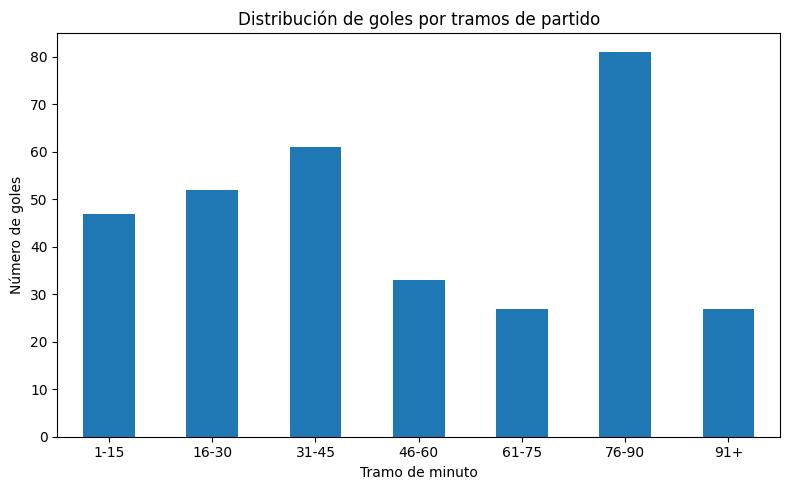

In [8]:
# Crear tramos de minutos
max_minute = int(scorers_df["minute"].max())

n_bins = max_minute // MINUTE_SEGMENTS 
bins = [i * MINUTE_SEGMENTS for i in range(n_bins + 1)]
bins.append(max_minute)

labels = [
    f"{bins[i] + 1}+"
    if i == len(bins) - 2
    else f"{bins[i] + 1}-{bins[i + 1]}"
    for i in range(len(bins) - 1)
]

scorers_df["minute_bin"] = pd.cut(
    scorers_df["minute"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Contar goles por tramo (excluyendo propios en este dataset own_goal es NaN cuando NO lo es)
goals_by_bin = (
    scorers_df
    .loc[scorers_df["own_goal"].isna()]
    .groupby("minute_bin", observed=True)
    .size()
)

# Pintar gráfico de barras
plt.figure(figsize=(8, 5))
goals_by_bin.plot(kind="bar")

plt.xlabel("Tramo de minuto")
plt.ylabel("Número de goles")
plt.title("Distribución de goles por tramos de partido")
plt.xticks(rotation=0)
plt.tight_layout()

# Guardar el gráfico como PNG
plt.savefig(OUTPUT_DIR + "/" + MINUTE_SEGMENTS_FILE_NAME, dpi=300, bbox_inches="tight")

# Mostrar el gráfico
plt.show()